In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.impute import SimpleImputer


# понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# модели кластеризации
from sklearn.cluster import KMeans, DBSCAN

import warnings
warnings.filterwarnings('ignore')

/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Кластеризация. Метод K-Means. Домашнее задание

## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [2]:
df_mall = pd.read_csv('data/Mall_Customers.csv', index_col='CustomerID')
df_mall.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### Задание 3

Преобразуйте категориальный признак Genre в численный.

In [3]:
df_mall = pd.concat([df_mall, pd.get_dummies(df_mall['Genre'], prefix='Gender', drop_first=False, dtype='int8')], axis=1)

In [4]:
df_mall.drop('Genre', axis=1, inplace=True)
df_mall.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0


In [5]:
# Построим матрицу корреляции для выявления линейной зависимоти

df_corr = df_mall
corr_matrix = df_corr.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

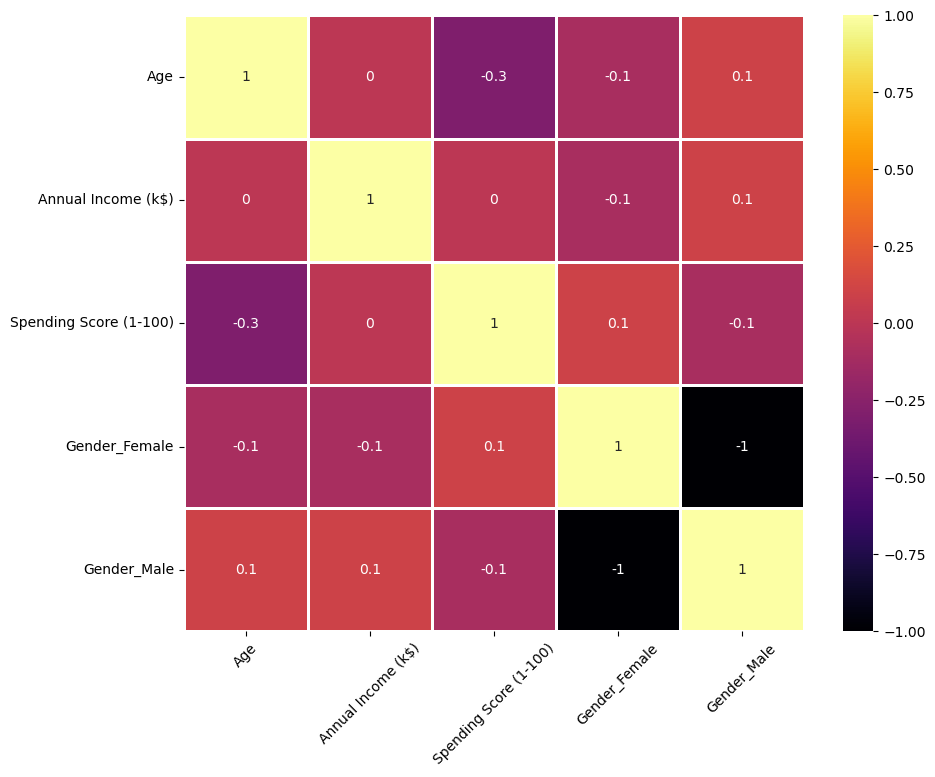

In [6]:
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='inferno')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

In [7]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(df_mall)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(df_mall))

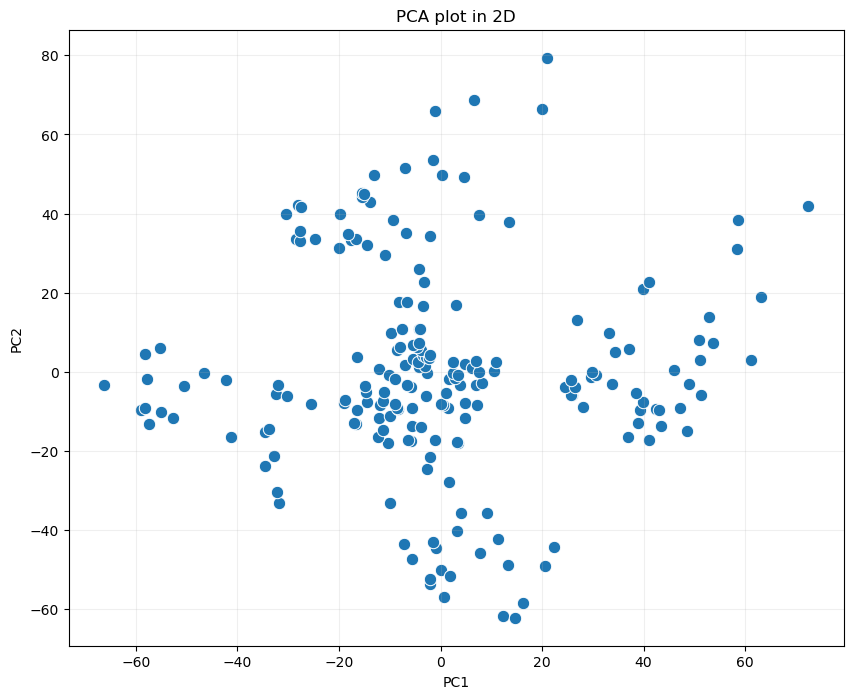

In [8]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                s=80,)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.2)

### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

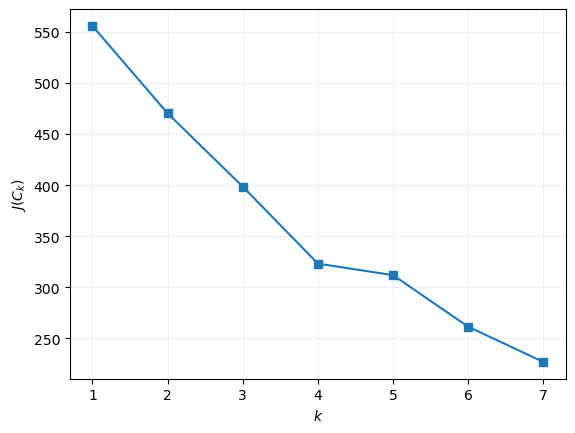

In [9]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(df_mall)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$")
plt.grid(alpha=0.2)

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

In [10]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto').fit(df_mall)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(df_mall))

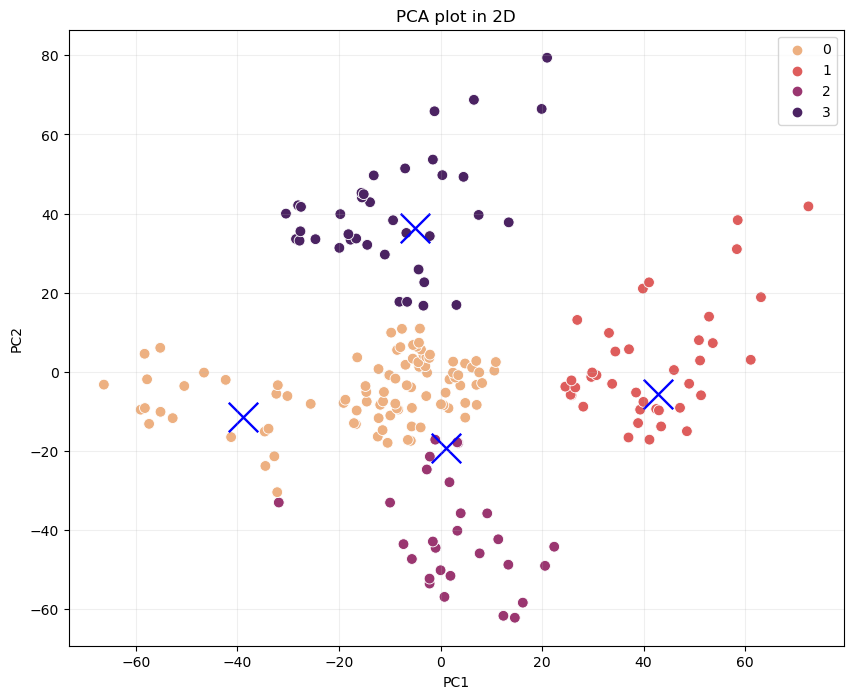

In [11]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_k,
                palette="flare",
                s=60)
sns.scatterplot(x = centroids_pca[:,0],
                y =  centroids_pca[:,1],
                marker="x",
                s=450,
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');
plt.grid(alpha=0.2)

# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [12]:
df_gt = pd.read_csv('data/gt_2015.csv')
df_gt.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [13]:
df_gt.shape

(7384, 11)

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

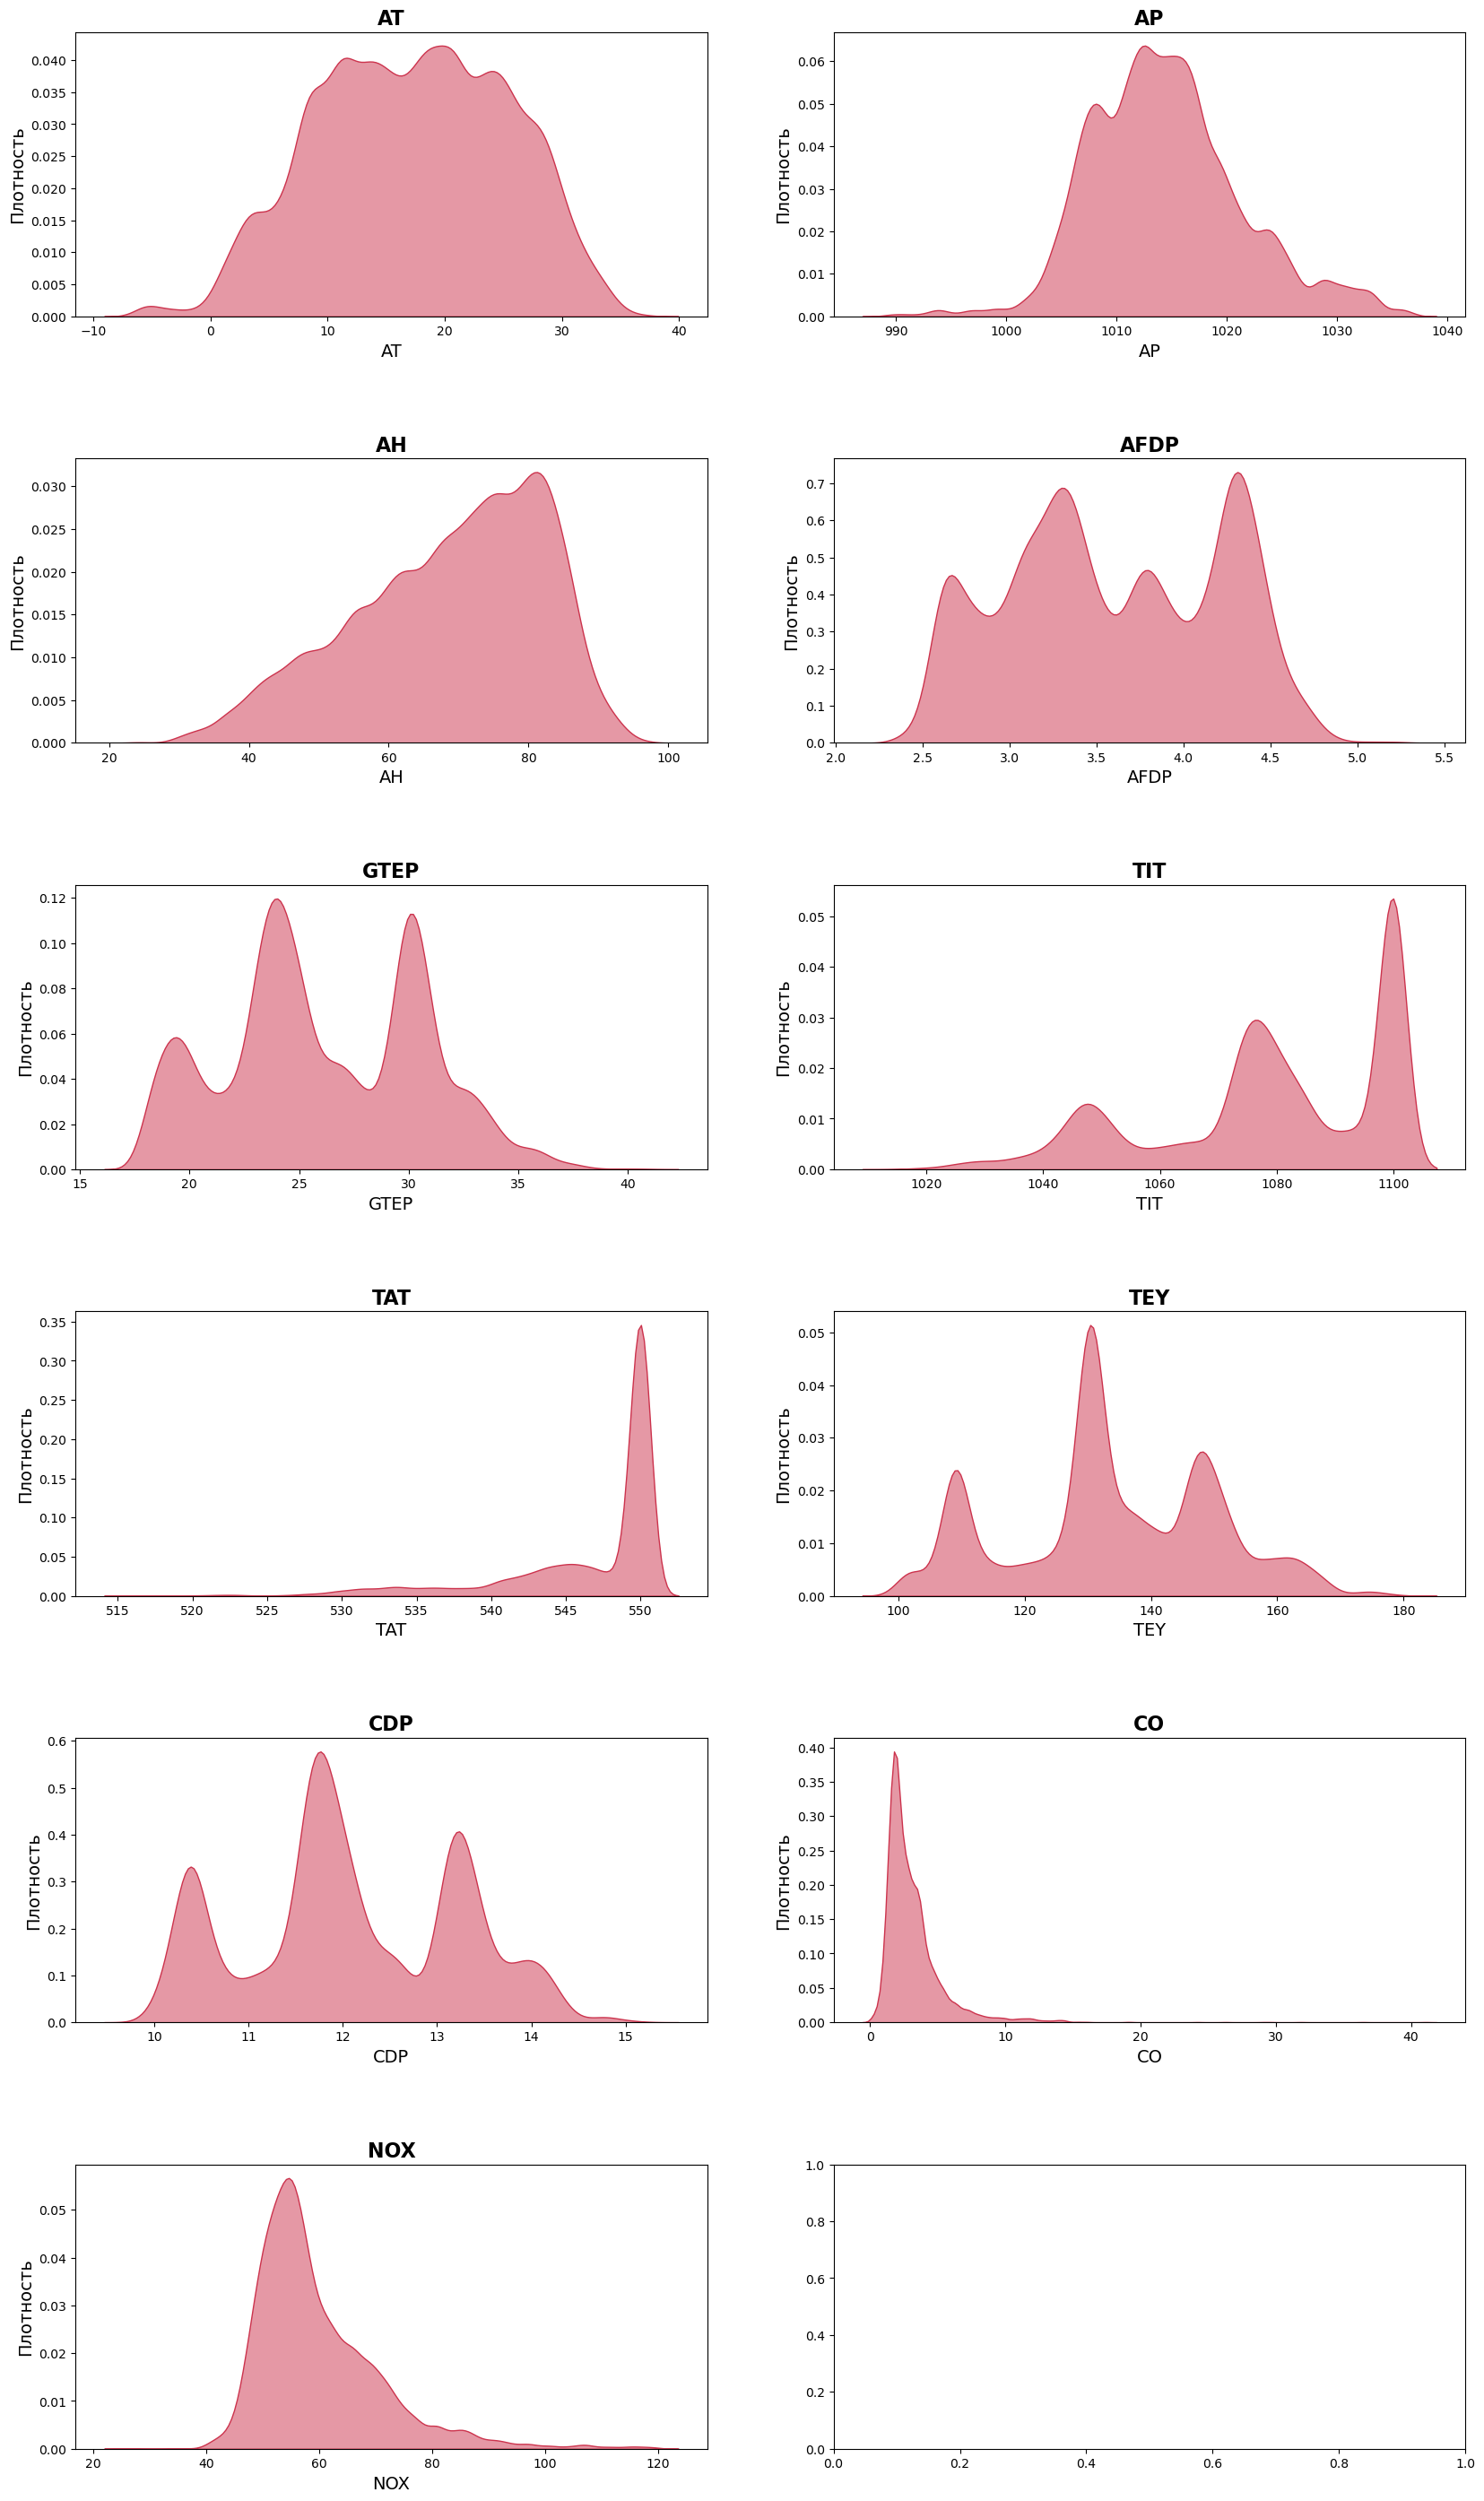

In [14]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(6,2, figsize = (20,35))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = df_gt.columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_gt,
                x = column,
                fill = True,
                alpha = 0.5,
                bw_adjust=.7,
                color = [0.8, 0.2, 0.3],
                ax = ax)

    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)


plt.show()

* Некоторые признаки близки к нормальному распределению (NOX, AP)
* Остальные признаки имеют скос или несколько мод (в основном 3: TIT, GTEP, TEY, CDP)
* Явновыраженных выбросов не обнаружено
* Признаки имеют разные масштабы измерений. Есть и сходство, но в основном различие на порядок

* TIT - температура на входе в турбину, 
* GTEP - давление на выходе из газовой турбины, 
* TEY - энергоотдача турбины, 
* CDP - давление нагнетания компрессора.

## Масштабирование
Из того, что большинство признаков имеют отличное от нормального распределение, следует, что стандартизация не лучший вариант. Вместно нее лучше подойдет MinMax.

In [15]:
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(df_gt), columns=df_gt.columns)

Для уменьшения размерности, воспользуевмся методом главных компонент и уменьшим размерность данных, потеряв наименьшее количество информации

In [16]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

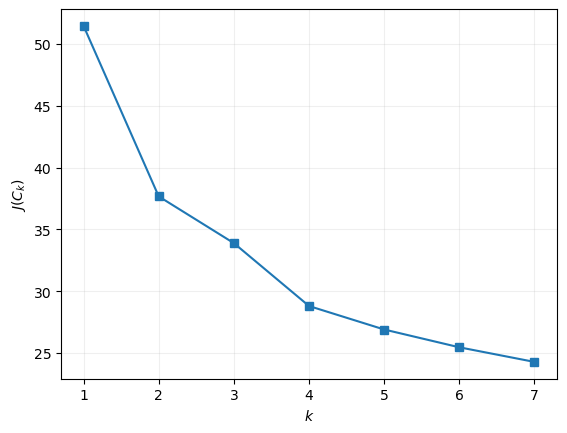

In [17]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$")
plt.grid(alpha=0.2)

### Построим распределения по каждому кластеру

In [18]:
df_cluster = X.copy()
df_cluster['K-Means'] = pred_k

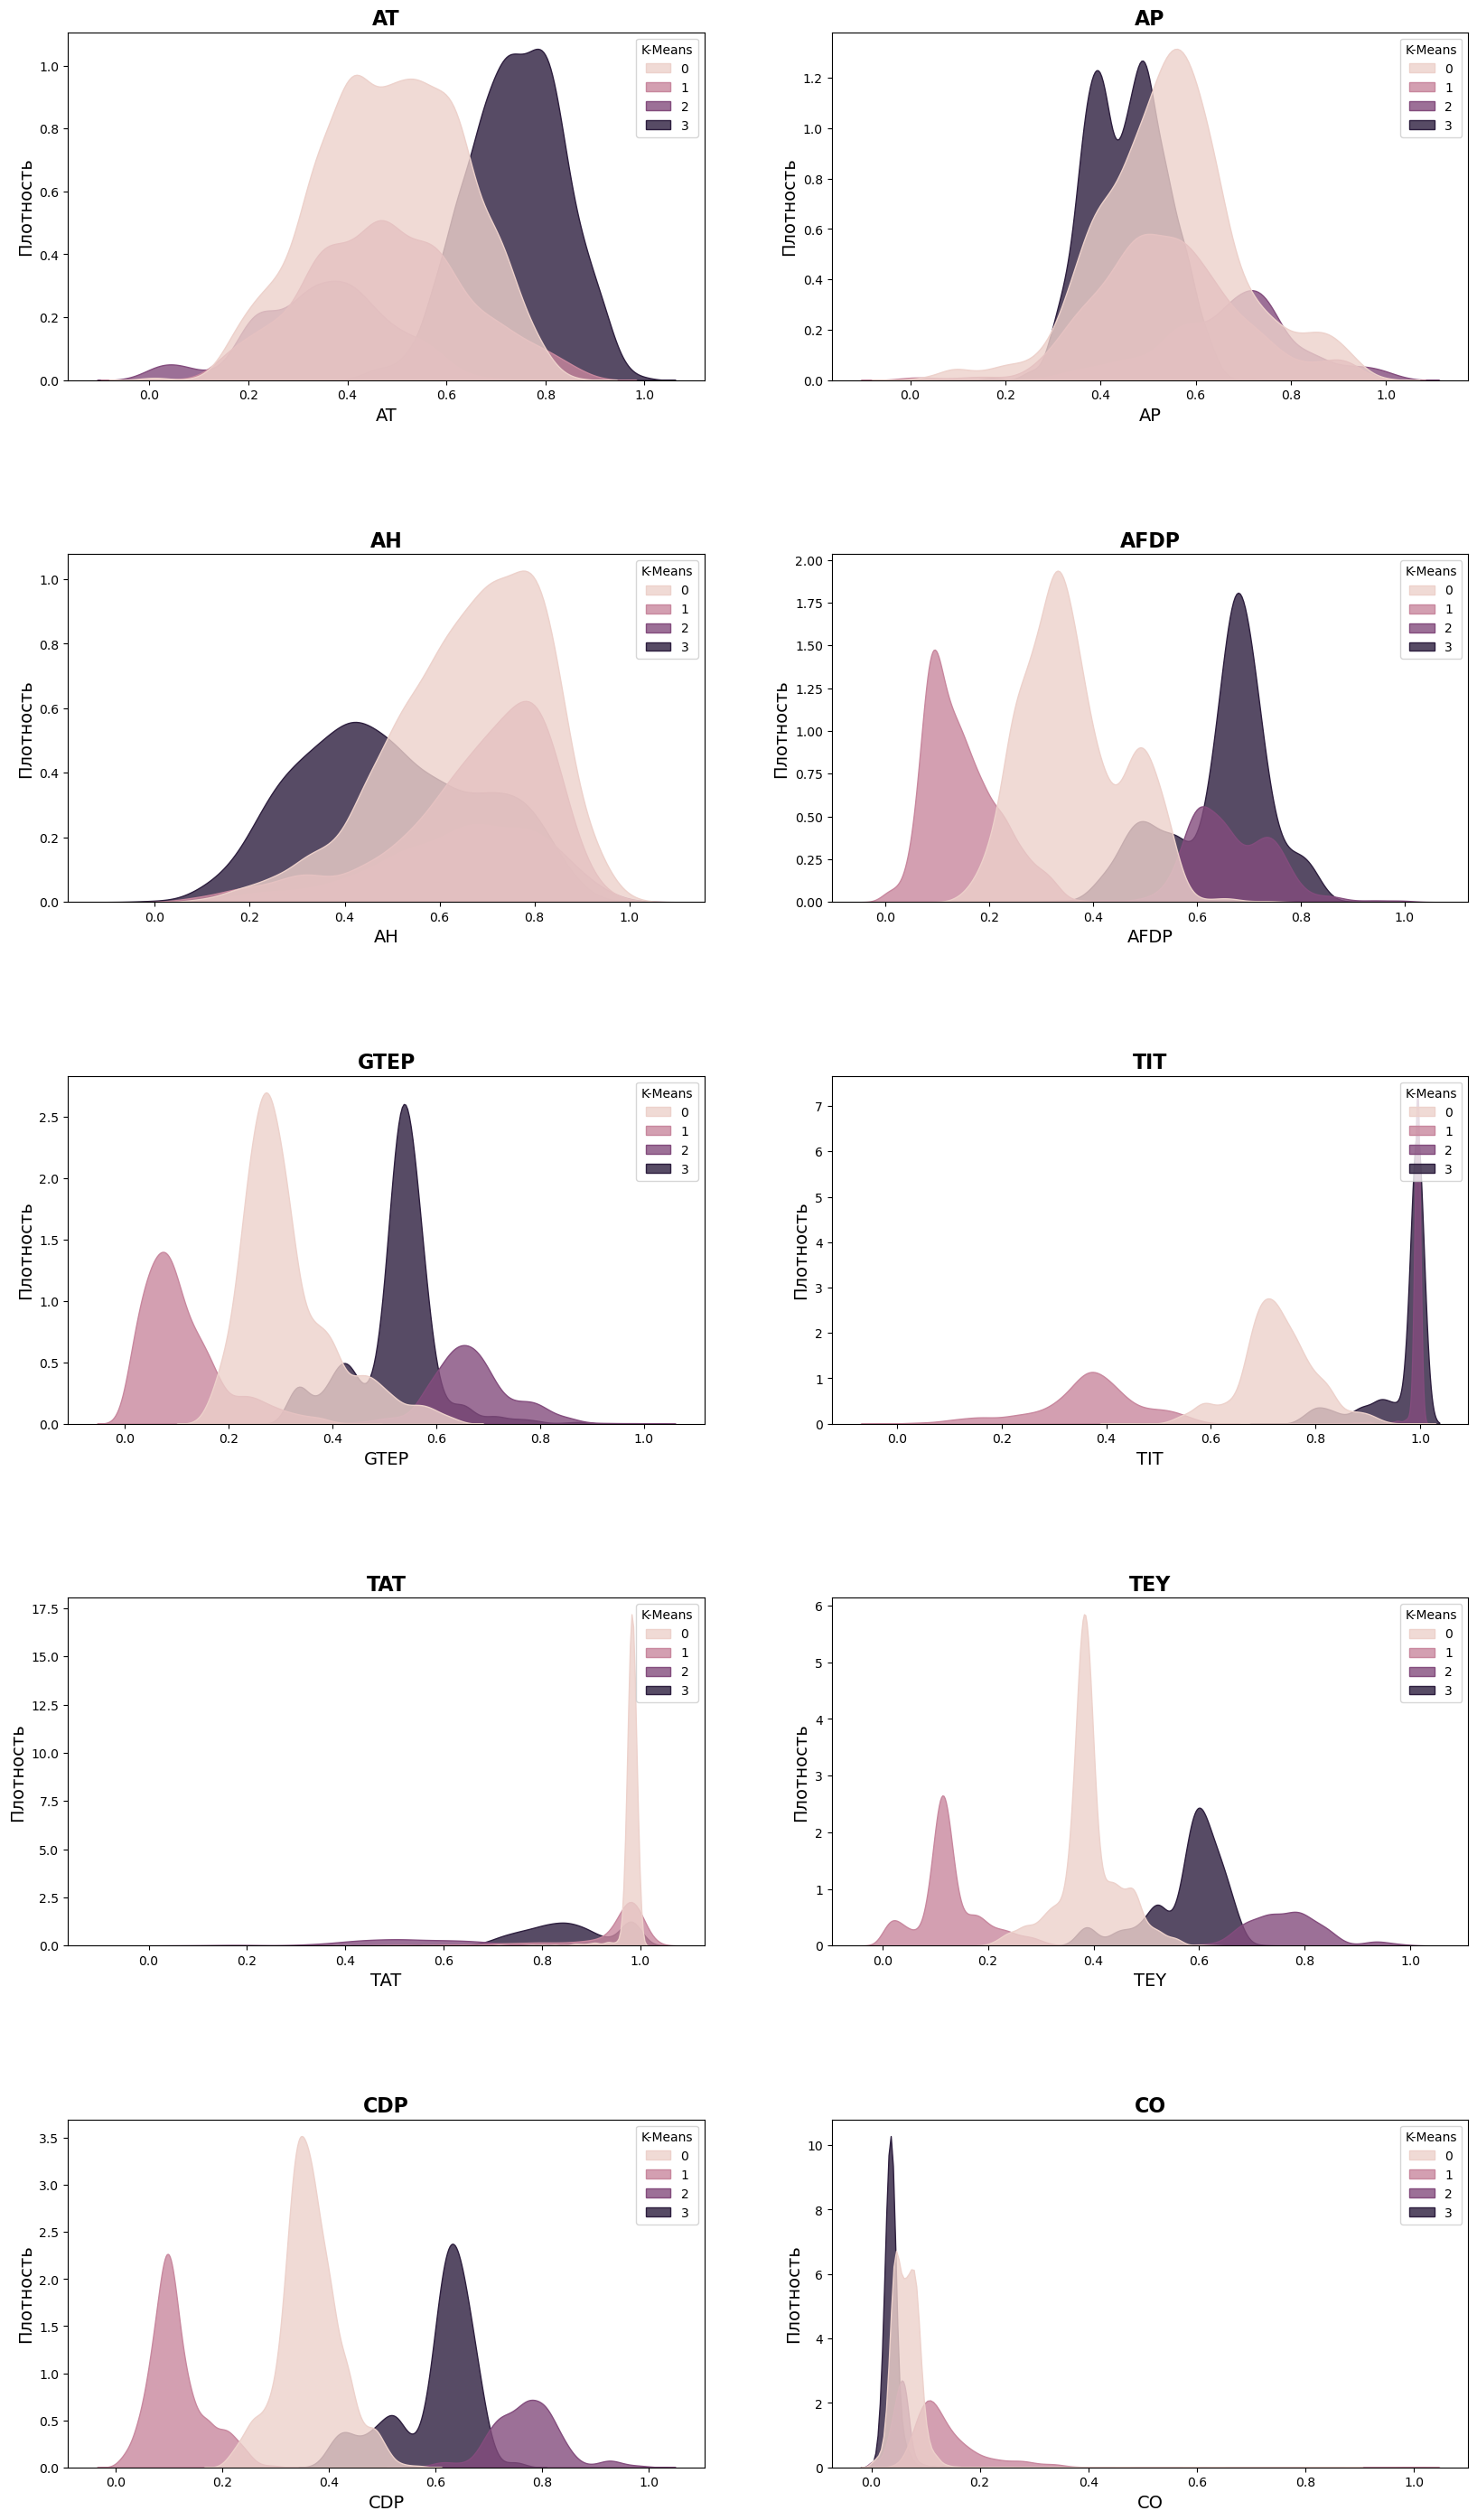

In [19]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(5,2, figsize = (20,35))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = X.columns[:-1]

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_cluster,
                x = column,
                fill = True,
                alpha = 0.8,
                hue = 'K-Means',
                ax = ax)

    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)


plt.show()

### Можно сделать вывод по данному графикам, что в данном наборе данных существует 4 категории станциц

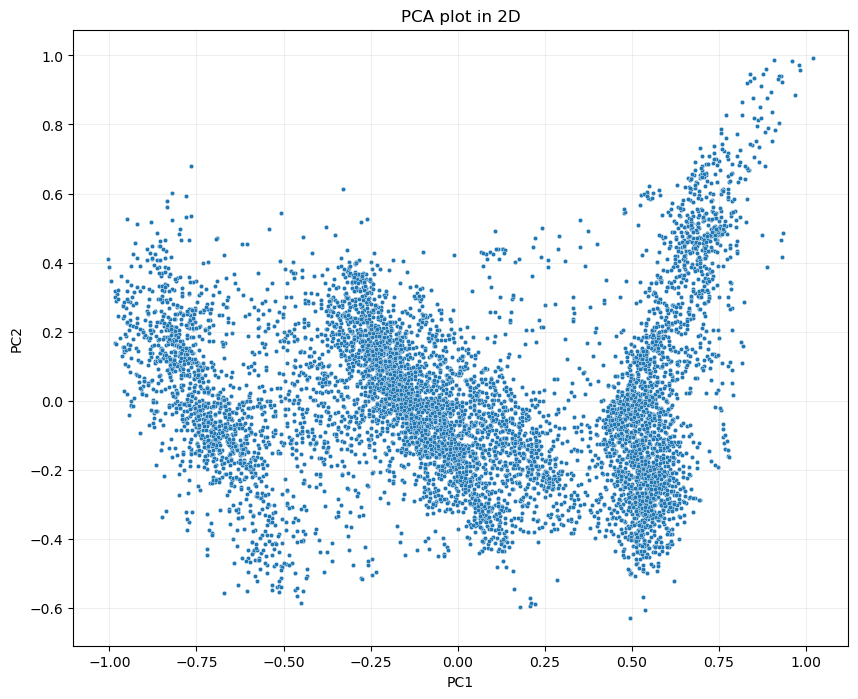

In [20]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                s=10,)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.2)

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

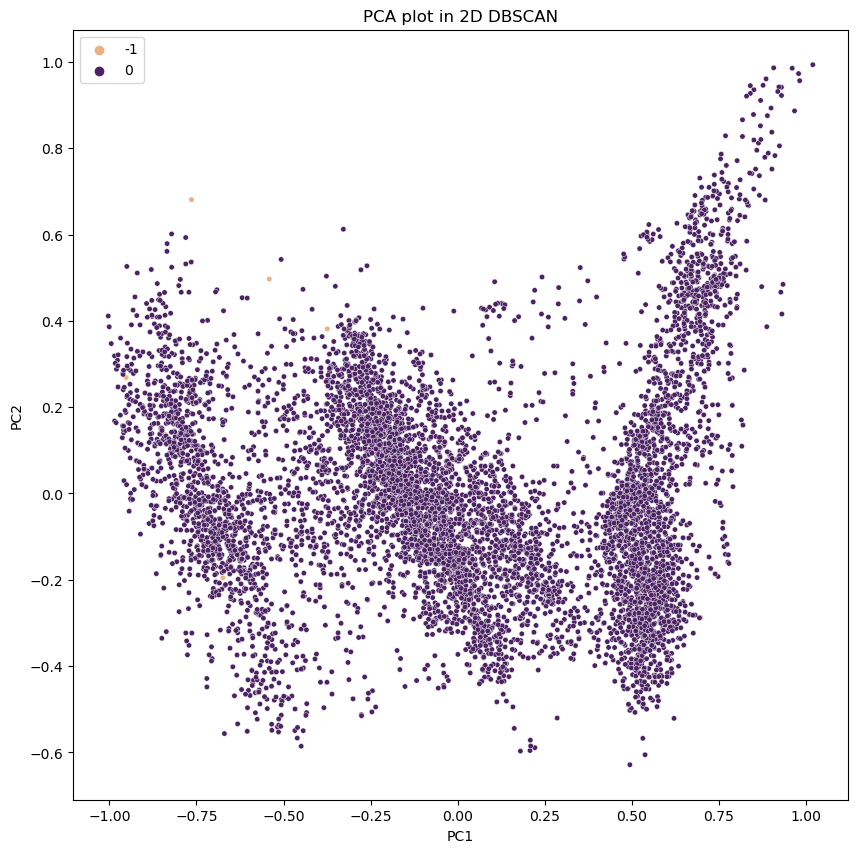

In [21]:
from sklearn.cluster import DBSCAN
clustering_db = DBSCAN(eps=0.5, min_samples=10).fit(X)
pred_db = clustering_db.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_db,
                palette="flare",
                s=15)
plt.title('PCA plot in 2D DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [22]:
# DBSCAN отнес все пракстически к одному кслассу, хотя на графике можно увидеть класстеризации по соседним точкам.

In [23]:
pca = PCA(n_components=2)


kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

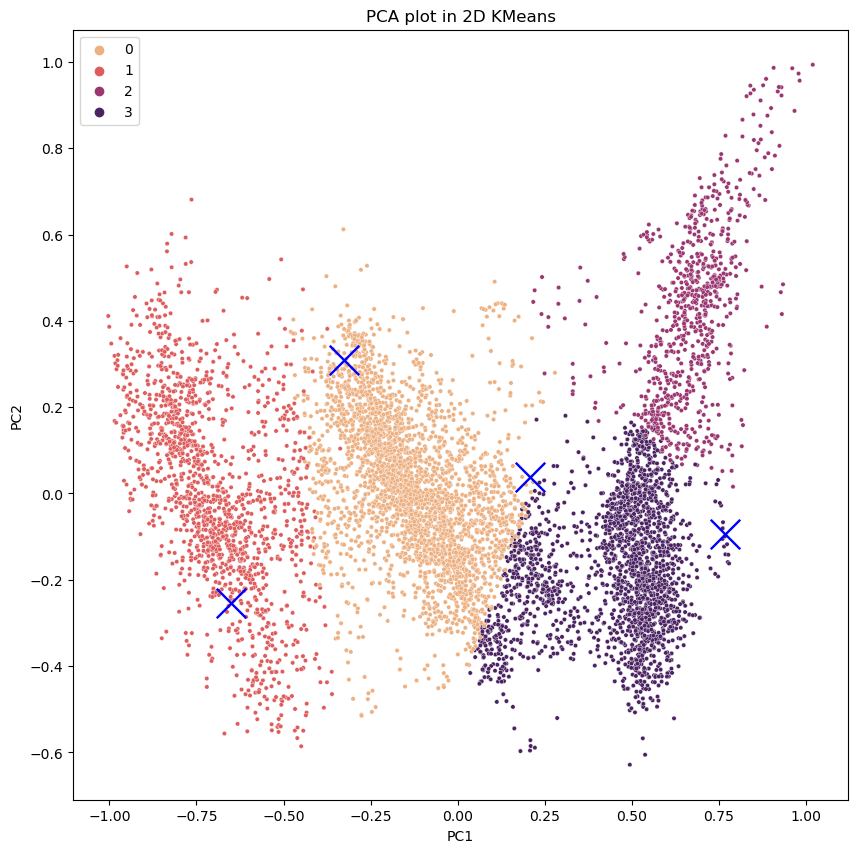

In [24]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_k,
                palette="flare",
                s=10)
sns.scatterplot(x = centroids_pca[:,0],
                y =  centroids_pca[:,1],
                marker="x",
                s=450,
                color = 'blue')
plt.title('PCA plot in 2D KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.

* DBSCAN отнес все пракстически к одному кслассу, K-means справился немного лучше. 
* Результаты получилсь не очень хорошими, возможно имеются выбросы. Для того чтобы их обработать необходимо разбираться в предметной области, либо орьатится к специалисту.